In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA, PCA
from sklearn import linear_model

In [2]:
# Read in the sequence information for E. coli
coli_nosc_df = pd.read_csv('../data/genomes/Coli/MG1655/MG1655_ref_prot_NOSC.csv').set_index('b_number')

# Read in matching proteomics
coli_expression_df = pd.read_csv('../data/proteomes/Coli/Chure_mean_absolute_measurements.csv')

# Sum the total measured mass per condition.
mass_totals = coli_expression_df.groupby('condition').sum()['fg_per_cell']
per_entry_mass_total = mass_totals.loc[coli_expression_df.condition].values

# Calculate the relative mass, i.e. the fraction of measured mass associated with this protein.
coli_expression_df['rel_mass'] = coli_expression_df.fg_per_cell / per_entry_mass_total

# Read in condition-wise Z_C,P values
coli_NOSC_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')

# Take only the Schmidt 2016 chemostat data for the initial analysis
mask = np.logical_and(coli_expression_df.dataset == 'schmidt_2016',
                      coli_expression_df.condition.str.startswith('chemo'))
coli_chemostat_exp_df = coli_expression_df[mask].reset_index().drop('index', axis=1).copy()
coli_chemostat_exp_df.head()


,b_number,dataset,strain,condition,growth_rate_hr,copies_per_cell,fg_per_cell,NOSC,NC_per,num_aas,mw_daltons,organism_key,species,majority_protein_ids,fraction_transmembrane,Ce_per,Ce_total,NC_total,rel_mass
0,b0167,schmidt_2016,BW25113,chemostat_u0.12,0.12,127.024316,0.021590,-0.126187,4569.0,890,102390,coli,E. coli,P27249,0.0,-576.55,-73235.869592,580374.101406,0.000141
1,b0167,schmidt_2016,BW25113,chemostat_u0.2,0.20,130.498622,0.022181,-0.126187,4569.0,890,102390,coli,E. coli,P27249,0.0,-576.55,-75238.980288,596248.202123,0.000135
2,b0167,schmidt_2016,BW25113,chemostat_u0.35,0.35,145.597485,0.024747,-0.126187,4569.0,890,102390,coli,E. coli,P27249,0.0,-576.55,-83944.230227,665234.910947,0.000131
3,b0167,schmidt_2016,BW25113,chemostat_u0.5,0.50,158.893445,0.027007,-0.126187,4569.0,890,102390,coli,E. coli,P27249,0.0,-576.55,-91610.015872,725984.151447,0.000125
4,b3725,schmidt_2016,BW25113,chemostat_u0.12,0.12,48.345076,0.002329,-0.159026,1293.0,257,29027,coli,E. coli,P0AAH0,0.0,-205.62,-9940.714450,62510.182784,0.000015


In [3]:
coli_expression_df[coli_expression_df.dataset == 'schmidt_2016'].condition.unique()

# Enumerating the non-stress conditions in Schmidt et al.
conds = ['acetate', 'chemostat_u0.12', 'chemostat_u0.2',
       'chemostat_u0.35', 'chemostat_u0.5', 'fructose', 'fumarate',
       'galactose', 'glucosamine', 'glucose', 'glycerol', 'glycerol_pAA',
       'lb_miller', 'mannose', 'pyruvate', 'succinate', 'xylose']
mask = np.logical_and(coli_expression_df.dataset == 'schmidt_2016',
                      coli_expression_df.condition.isin(conds))
coli_nonstress_exp_df = coli_expression_df[mask].reset_index().drop('index', axis=1).copy()

In [4]:
index_cols = 'condition,growth_rate_hr'.split(',')
mask = np.logical_or(coli_nonstress_exp_df.Ce_total.notnull(), coli_nonstress_exp_df.NC_total.notnull())

# Calculate each proteins' contribution to proteome Z_C in
# each condition by taking the ratio Ce_total/NC_total where 
# Ce_total = tot_per_cell*NC*NOSC and NC_total = tot_per_cell*NC
mat_Ce_tot = coli_nonstress_exp_df[mask].pivot_table(index='b_number', values='Ce_total', columns=index_cols)
mat_NC_tot = coli_nonstress_exp_df[mask].pivot_table(index='b_number', values='NC_total', columns=index_cols)

# The sign of principal component loadings are confusing here because 
# Ce_total and Z_C values are almost uniformly negative. Could potentially
# invert here, but instead we'll just look for large absolute loadings. 
mat_Ce_normd = mat_Ce_tot / mat_NC_tot.sum()
mat_Ce_normd = mat_Ce_normd.replace({np.NaN: 0})
fit_pca = PCA(n_components=2).fit(mat_Ce_normd.T)
# blame_i = NOSC*NC*x_i / (sum_i (NC*x_i))

# First component explains about 96% of the variation in the Schmidt chemostat conds. 
pct_var = fit_pca.explained_variance_ratio_*100
print('Fit PC1 "explains" {0:.2f}% of Z_C variation'.format(pct_var[0]))
print('Fit PC2 "explains" {0:.2f}% of Z_C variation'.format(pct_var[1]))

Fit PC1 "explains" 68.18% of Z_C variation
Fit PC2 "explains" 12.27% of Z_C variation


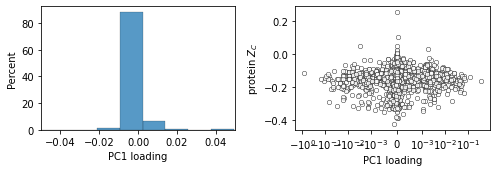

In [5]:
# Peek at the first component loadings
loadings = fit_pca.components_
first_comp = loadings[0,:]

fig, axs = plt.subplots(ncols=2, figsize=(7,2.5))
plt.sca(axs[0])
sns.histplot(first_comp, bins=100, stat="percent")
plt.xlabel('PC1 loading')
plt.xlim(-0.05, 0.05)

plt.sca(axs[1])
NOSC = coli_nosc_df.loc[mat_Ce_tot.index].NOSC
plt.xscale('symlog', linthresh=0.001)
plt.scatter(first_comp, NOSC, s=20, color='w', edgecolors='k', lw=0.5, alpha=0.8)
plt.ylabel('protein $Z_C$')
plt.xlabel('PC1 loading')

plt.tight_layout()
plt.show()

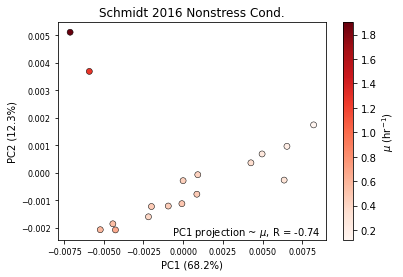

In [6]:
# PC1 of NOSC data correlates well with growth rate. 
# qn: is this just that expression correlates with growth? 
# can compare to expression only and see if this improves things. 
conds_proj = fit_pca.transform(mat_Ce_normd.T)
gr_dict = dict(mat_Ce_normd.columns)
grs = [gr for k,gr in mat_Ce_normd.columns]

pearson_r = np.corrcoef(conds_proj[:,0], grs)[0,1]

cmap = sns.color_palette('Reds', as_cmap=True)
plt.figure()
plt.scatter(conds_proj[:,0], conds_proj[:,1], c=grs, edgecolor='k', lw=0.5, cmap=cmap)
plt.xlabel('PC1 ({0:.1f}%)'.format(fit_pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 ({0:.1f}%)'.format(fit_pca.explained_variance_ratio_[1]*100))
plt.colorbar(label='$\mu$ (hr$^{-1}$)')
plt.text(0.98, 0.02, 'PC1 projection ~ $\mu$, R = {0:.2f}'.format(pearson_r),
         transform=plt.gca().transAxes, ha='right')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Schmidt 2016 Nonstress Cond.')
plt.savefig('../output/all_coli_PCA_projection.png', facecolor='w', dpi=300)
plt.show()

alpha = 1e-06 = 10^-6
8 nonzero terms
Coefficients: [10.41722424  4.90561912  7.62991983  1.52063842  2.30477692  7.68848549
  2.35071273  1.51689215]
alpha = 1e-07 = 10^-7
14 nonzero terms
Coefficients: [1.07286350e+01 7.59387225e+00 6.73761067e+00 1.22827587e+00
 1.51677564e-02 9.32615141e-01 3.32524534e+00 6.00613144e+00
 3.90187619e+00 4.15602866e+00 1.88657549e-01 3.98717138e-03
 7.17013766e+00 7.40974421e-01]
alpha = 1e-08 = 10^-8
18 nonzero terms
Coefficients: [1.73833596e+01 1.05997027e+01 6.49460046e-01 1.09089878e+01
 1.05897709e+00 1.79699129e+00 1.15567715e+00 5.24066259e+00
 8.21243782e+00 4.14419437e+00 2.35333079e-03 2.43426004e+00
 3.04604144e+00 1.57765805e+00 1.30407998e+00 1.08890197e-01
 5.54401698e-02 4.44901060e+00]
alpha = 1e-09 = 10^-9
38 nonzero terms
Coefficients: [2.33663178e+01 6.62878596e+01 3.72279934e+01 6.59763963e+00
 3.33449584e+00 6.73477440e+00 2.50823086e+00 4.81829913e+00
 1.58985738e+01 6.75250187e-01 3.09957249e+01 1.60048111e+01
 3.05636790e-01 

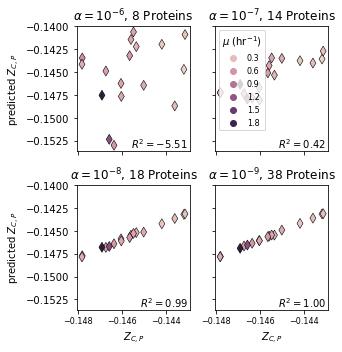

In [7]:
# Perform and plot predictive accuracy Sparse regression for different levels of sparsity.
# Response variable is the whole proteome Z_C,P
schmidt_data = coli_NOSC_data[coli_NOSC_data.dataset == 'schmidt_2016'].set_index('condition')
b = schmidt_data.loc[mat_Ce_normd.columns.levels[0]].proteome_NOSC

# Regressed against individual contributions of proteins. 
# Obviously we can predict b from A because b is a linear combination of the entries
# of A by the definition of Z_C. However this analysis asks how well b can be predicted
# from a small subset of the entries in A by altering the sparsity parameter alpha 
# of a Lasso-style regression. The result is that you only need ~10 proteins data to 
# get near-perfect prediction.
A = mat_Ce_normd.T

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4.76, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()
alphas = np.logspace(-6, -9, 4)
for i,a in enumerate(alphas):
    # Requiring positive contributions to focus on genes positively correlated with the trend.
    # Not fitting an intercept since the chemical relationship has 0 intercept.  
    reg = linear_model.Lasso(alpha=a, max_iter=100000, fit_intercept=False, positive=True)
    reg.fit(A, b)
    
    nz_coeff = reg.coef_[reg.coef_ != 0]
    print('alpha = {0} = 10^{1}'.format(a, int(np.log10(a))))
    print('{0} nonzero terms'.format(nz_coeff.size))
    print('Coefficients:', nz_coeff)

    # Make a temporary DF for plotting
    pred_b = reg.predict(A)
    _plot_df = pd.DataFrame(dict(b=b, pred_b=pred_b, mu=schmidt_data.loc[b.index].growth_rate_hr))
    
    plt.sca(flat_axs[i])
    
    sns.scatterplot(data=_plot_df, x='b', y='pred_b', hue='mu', edgecolor='k', lw=0.5, marker='d', s=50)
    plt.title('$\\alpha = 10^{{{0}}}$, {1} Proteins'.format(int(np.log10(a)), nz_coeff.size))
    plt.legend().set_visible(False)
    plt.text(0.98, 0.02, '$R^2 = {{{0:.2f}}}$'.format(reg.score(A, b)),
             transform=plt.gca().transAxes, ha='right')
    
    if i == 1:
        plt.legend(title='$\mu$ (hr$^{-1}$)', loc=2, fontsize=8).set_visible(True)
    if i % 2 == 0:
        plt.ylabel('predicted $Z_{C,P}$')
    if i > 1:
        plt.xlabel('$Z_{C,P}$')
        plt.xticks(fontsize=8)
    
#plt.legend(title='$\mu$ (hr$^{-1}$)')
#plt.xlabel('$Z_{C,P}$')
#plt.ylabel('Predicted $Z_{C,P}$')

plt.tight_layout()
plt.show()

In [8]:
nz_coeff = reg.coef_[reg.coef_ != 0]
print('{0} nonzero terms'.format(nz_coeff.size))
print('Coefficients:', nz_coeff)

nonzero_b_numbers = mat_Ce_normd.loc[reg.coef_ != 0].index
cols = 'primary_accession,gene_name,description,NC,NOSC,Ce_total'.split(',')
coli_nosc_df.loc[nonzero_b_numbers][cols]

38 nonzero terms
Coefficients: [2.33663178e+01 6.62878596e+01 3.72279934e+01 6.59763963e+00
 3.33449584e+00 6.73477440e+00 2.50823086e+00 4.81829913e+00
 1.58985738e+01 6.75250187e-01 3.09957249e+01 1.60048111e+01
 3.05636790e-01 7.86707201e+00 8.27406515e+00 1.00340292e+00
 2.97046290e+00 8.77953365e-01 2.55211828e+00 1.21743801e+00
 2.57231562e+00 1.23458417e+00 5.30519948e+00 1.59038005e+00
 3.61896454e-02 1.10580026e+01 2.90810158e+00 1.37389191e-04
 1.50911799e-01 6.33948355e+00 9.41719890e-01 1.65022009e+00
 2.28832366e+00 2.12571558e+00 8.84949152e-02 2.70121108e+00
 1.61699103e-02 8.72742904e-01]


,primary_accession,gene_name,description,NC,NOSC,Ce_total
b_number,,,,,,
b0014,P0A6Y8,dnaK,Chaperone protein DnaK,3001.0,-0.122066,-366.32
b0033,P00968,carB,Carbamoyl-phosphate synthase large chain,5190.0,-0.143264,-743.54
b0073,P30125,leuB,3-isopropylmalate dehydrogenase,1748.0,-0.125578,-219.51
b0074,P09151,leuA,2-isopropylmalate synthase,2506.0,-0.105946,-265.50
b0115,P06959,aceF,Dihydrolipoyllysine-residue acetyltransferase ...,2930.0,-0.198014,-580.18
b0116,P0A9P0,lpdA,Dihydrolipoyl dehydrogenase,2266.0,-0.195865,-443.83
b0118,P36683,acnB,Aconitate hydratase B,4164.0,-0.162166,-675.26
b0169,P0A7V0,rpsB,30S ribosomal protein S2,1185.0,-0.144996,-171.82
b0170,P0A6P1,tsf,Elongation factor Ts,1336.0,-0.176707,-236.08


Text(0.5, 1.0, 'Sparse Regression, 38 Nonzero Terms')

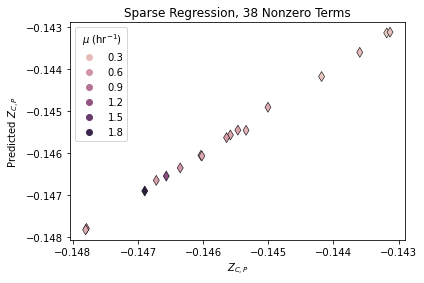

In [9]:
pred_b = reg.predict(A)
tmp = pd.DataFrame(dict(b=b, pred_b=pred_b, mu=schmidt_data.loc[b.index].growth_rate_hr))
sns.scatterplot(data=tmp, x='b', y='pred_b', hue='mu', edgecolor='k', lw=0.5, marker='d', s=50)
plt.legend(title='$\mu$ (hr$^{-1}$)')
plt.xlabel('$Z_{C,P}$')
plt.ylabel('Predicted $Z_{C,P}$')
plt.title('Sparse Regression, {0} Nonzero Terms'.format(nz_coeff.size))

In [10]:
corrs = coli_nonstress_exp_df.groupby('b_number').apply(lambda x: pearsonr(x.copies_per_cell, x.growth_rate_hr))
mean_by_protein = coli_nonstress_exp_df.groupby('b_number').mean()
mu_correlation = pd.DataFrame(corrs.tolist(), columns='R,P'.split(','), index=tmp.index)

# Bonferroni correction
mu_correlation['P_corrected'] = mu_correlation['P']*mu_correlation.P.size
mu_correlation['mean_rel_mass'] = mean_by_protein['rel_mass']
mu_correlation.head()

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ValueError: Shape of passed values is (2040, 2), indices imply (17, 2)

In [ ]:
plt.hist(coli_nonstress_exp_df.rel_mass, bins=100)
plt.xlim(0, 0.02)

In [ ]:
mask = np.logical_and(mu_correlation.P_corrected < 1e-3, mu_correlation.R > 0.9)
mask = np.logical_and(mu_correlation.mean_rel_mass > 1e-3, mask)
high_mu_corr = mu_correlation[mask].sort_values('mean_rel_mass', ascending=False)
high_mu_corr.shape

In [ ]:
coli_nosc_df.loc[high_mu_corr.index].to_csv('/Users/flamholz/Desktop/tmp.csv')